In [1]:
from pathlib import Path

DATA_DIR = Path.cwd().parent / "data"

DATA_DIR

PosixPath('/workspaces/isic/data')

In [2]:
TRAIN_IMAGES_FILE = DATA_DIR / "train-image.hdf5"
TRAIN_METADATA_FILE = DATA_DIR / "train-metadata.csv"

TRAIN_IMAGES_FILE, TRAIN_METADATA_FILE

(PosixPath('/workspaces/isic/data/train-image.hdf5'),
 PosixPath('/workspaces/isic/data/train-metadata.csv'))

# HDF5 Images


In [ ]:
import h5py

with h5py.File(TRAIN_IMAGES_FILE) as f:
    total = len(f.keys())
    print(f"Total images: {total}")

Total images: 401059


In [ ]:
import io
import numpy as np
from PIL.Image import Image


def to_image(b: np.typing.ArrayLike) -> Image:
    from PIL import Image

    return Image.open(io.BytesIO(b))

# Image Size Distribution


peek the dataset


ISIC_0015670 (139, 139)


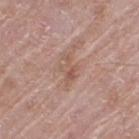

ISIC_0015845 (127, 127)


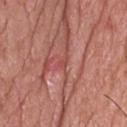

ISIC_0015864 (145, 145)


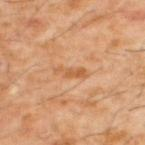

In [8]:
with h5py.File(TRAIN_IMAGES_FILE) as f:
    keys = list(f.keys())
    for key in keys[:3]:
        d = f[key]
        image = to_image(d[()])

        print(key, image.size)
        image.show()

In [10]:
with h5py.File(TRAIN_IMAGES_FILE) as f:
    keys = f.keys()
    images = [to_image(f[key][()]) for key in keys]

In [18]:
from matplotlib import pyplot as plt

# all squares
assert all(image.size[0] == image.size[1] for image in images)

sizes = [image.size[0] for image in images]

min(sizes), max(sizes)

(41, 269)

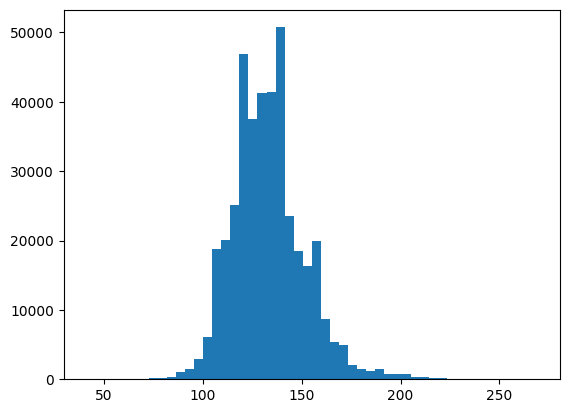

In [16]:
plt.hist([image.size[0] for image in images], bins=50)
plt.show()

# Image Scaling


Images are square images with sizes ranging from 41 to 269. Most images have sides between 100 and 150. Will rescale images to 128x128 for now, but scaling target should be a hyperparameter.


(41, 41)


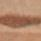

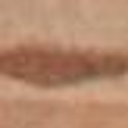

(45, 45)


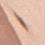

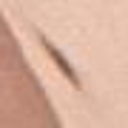

(45, 45)


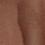

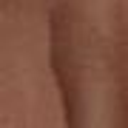

In [20]:
sorted_images = sorted(images, key=lambda i: i.size[0])

for image in sorted_images[:3]:
    print(image.size)
    image.show()
    image.resize((128, 128)).show()

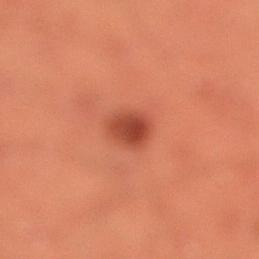

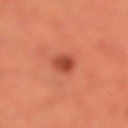

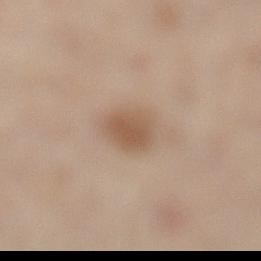

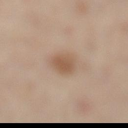

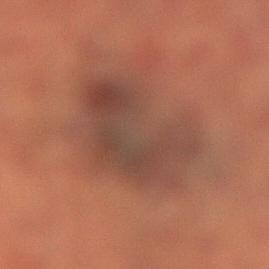

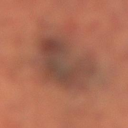

In [21]:
for image in sorted_images[-3:]:
    image.show()
    image.resize((128, 128)).show()

Larger images appear very blurry, likely not original scale.


# Metadata


In [22]:
import pandas as pd

df = pd.read_csv(TRAIN_METADATA_FILE, low_memory=False)

len(df)

401059

In [23]:
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


## Age


2,798 missing (~0.70%)


In [28]:
from sklearn.preprocessing import minmax_scale

minmax_scale(df["age_approx"].fillna(0))[:5]

array([0.70588235, 0.70588235, 0.70588235, 0.76470588, 0.64705882])

## Sex


11,517 missing (~2.87%)


In [29]:
from sklearn.preprocessing import OneHotEncoder

sex_enc = OneHotEncoder(categories=[["male", "female"]], handle_unknown="ignore")

sex_enc = sex_enc.fit(df[["sex"]])

x = sex_enc.transform(df[["sex"]]).toarray()

x.shape

(401059, 2)

## Anatomy Site


Location of the lesion on the patient's body.


In [ ]:
from sklearn.preprocessing import OneHotEncoder

anatom_site_general_enc = OneHotEncoder(
    categories=[
        [
            "head/neck",
            "upper extremity",
            "lower extremity",
            "posterior torso",
            "anterior torso",
        ]
    ],
    handle_unknown="ignore",
)

anatom_site_general_enc = anatom_site_general_enc.fit(df[["anatom_site_general"]])

x = anatom_site_general_enc.transform(df[["anatom_site_general"]]).toarray()

x.shape

(401059, 5)

Image Size Analysis:
Minimum size: 41px
Maximum size: 269px
Mean size: 133.2px
Median size: 131.0px
Standard deviation: 18.3px

Size percentiles:
5th percentile: 107px
10th percentile: 111px
25th percentile: 121px
50th percentile: 131px
75th percentile: 143px
90th percentile: 157px
95th percentile: 163px

🎯 Model Input Size Recommendations:
• Conservative (captures 90% of images): 224x224
• Balanced (captures 75% of images): 192x192
• Aggressive (captures 50% of images): 128x128


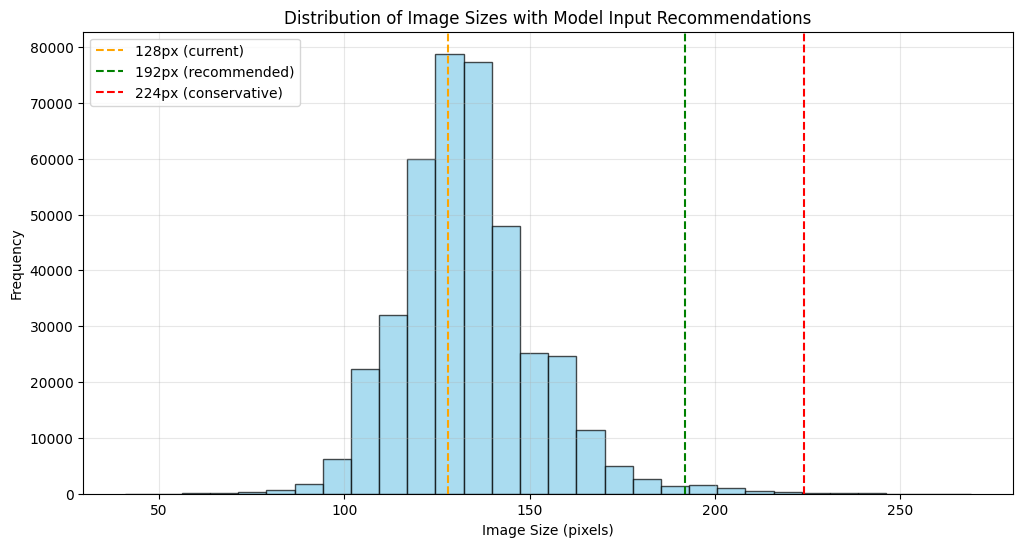


💾 Memory Usage Estimates (batch_size=32):
128x128: ~6.0 MB per batch
192x192: ~13.5 MB per batch
224x224: ~18.4 MB per batch
256x256: ~24.0 MB per batch


In [ ]:
# Analyze image sizes to determine optimal input resolution
image_sizes = [image.size[0] for image in images]  # All images are square

# Statistical analysis of image sizes
print("Image Size Analysis:")
print(f"Minimum size: {min(image_sizes)}px")
print(f"Maximum size: {max(image_sizes)}px")
print(f"Mean size: {np.mean(image_sizes):.1f}px")
print(f"Median size: {np.median(image_sizes):.1f}px")
print(f"Standard deviation: {np.std(image_sizes):.1f}px")

# Percentiles
percentiles = [5, 10, 25, 50, 75, 90, 95]
print("\nSize percentiles:")
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(image_sizes, p):.0f}px")

# Recommendations for model input sizes
print("\n🎯 Model Input Size Recommendations:")
print("• Conservative (captures 90% of images): 224x224")
print("• Balanced (captures 75% of images): 192x192")
print("• Aggressive (captures 50% of images): 128x128")

# Plot histogram with recommendations
plt.figure(figsize=(12, 6))
plt.hist(image_sizes, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
plt.axvline(128, color="orange", linestyle="--", label="128px (current)")
plt.axvline(192, color="green", linestyle="--", label="192px (recommended)")
plt.axvline(224, color="red", linestyle="--", label="224px (conservative)")
plt.xlabel("Image Size (pixels)")
plt.ylabel("Frequency")
plt.title("Distribution of Image Sizes with Model Input Recommendations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Memory analysis for different input sizes
input_sizes = [128, 192, 224, 256]
batch_size = 32
print(f"\n💾 Memory Usage Estimates (batch_size={batch_size}):")
for size in input_sizes:
    # Rough estimate: batch_size * channels * height * width * 4 bytes (float32)
    memory_mb = (batch_size * 3 * size * size * 4) / (1024**2)
    print(f"{size}x{size}: ~{memory_mb:.1f} MB per batch")

# Optimal Image Resolution Analysis



age_approx statistics:
Benign - Mean: 58.010, Std: 13.597
Malignant - Mean: 61.372, Std: 11.933

clin_size_long_diam_mm statistics:
Benign - Mean: 3.929, Std: 1.739
Malignant - Mean: 5.750, Std: 3.902

tbp_lv_A statistics:
Benign - Mean: 19.972, Std: 3.996
Malignant - Mean: 22.501, Std: 6.028

tbp_lv_Aext statistics:
Benign - Mean: 14.917, Std: 3.527
Malignant - Mean: 17.534, Std: 4.994

tbp_lv_B statistics:
Benign - Mean: 28.286, Std: 5.276
Malignant - Mean: 23.838, Std: 5.796

tbp_lv_Bext statistics:
Benign - Mean: 26.915, Std: 4.483
Malignant - Mean: 24.950, Std: 4.497


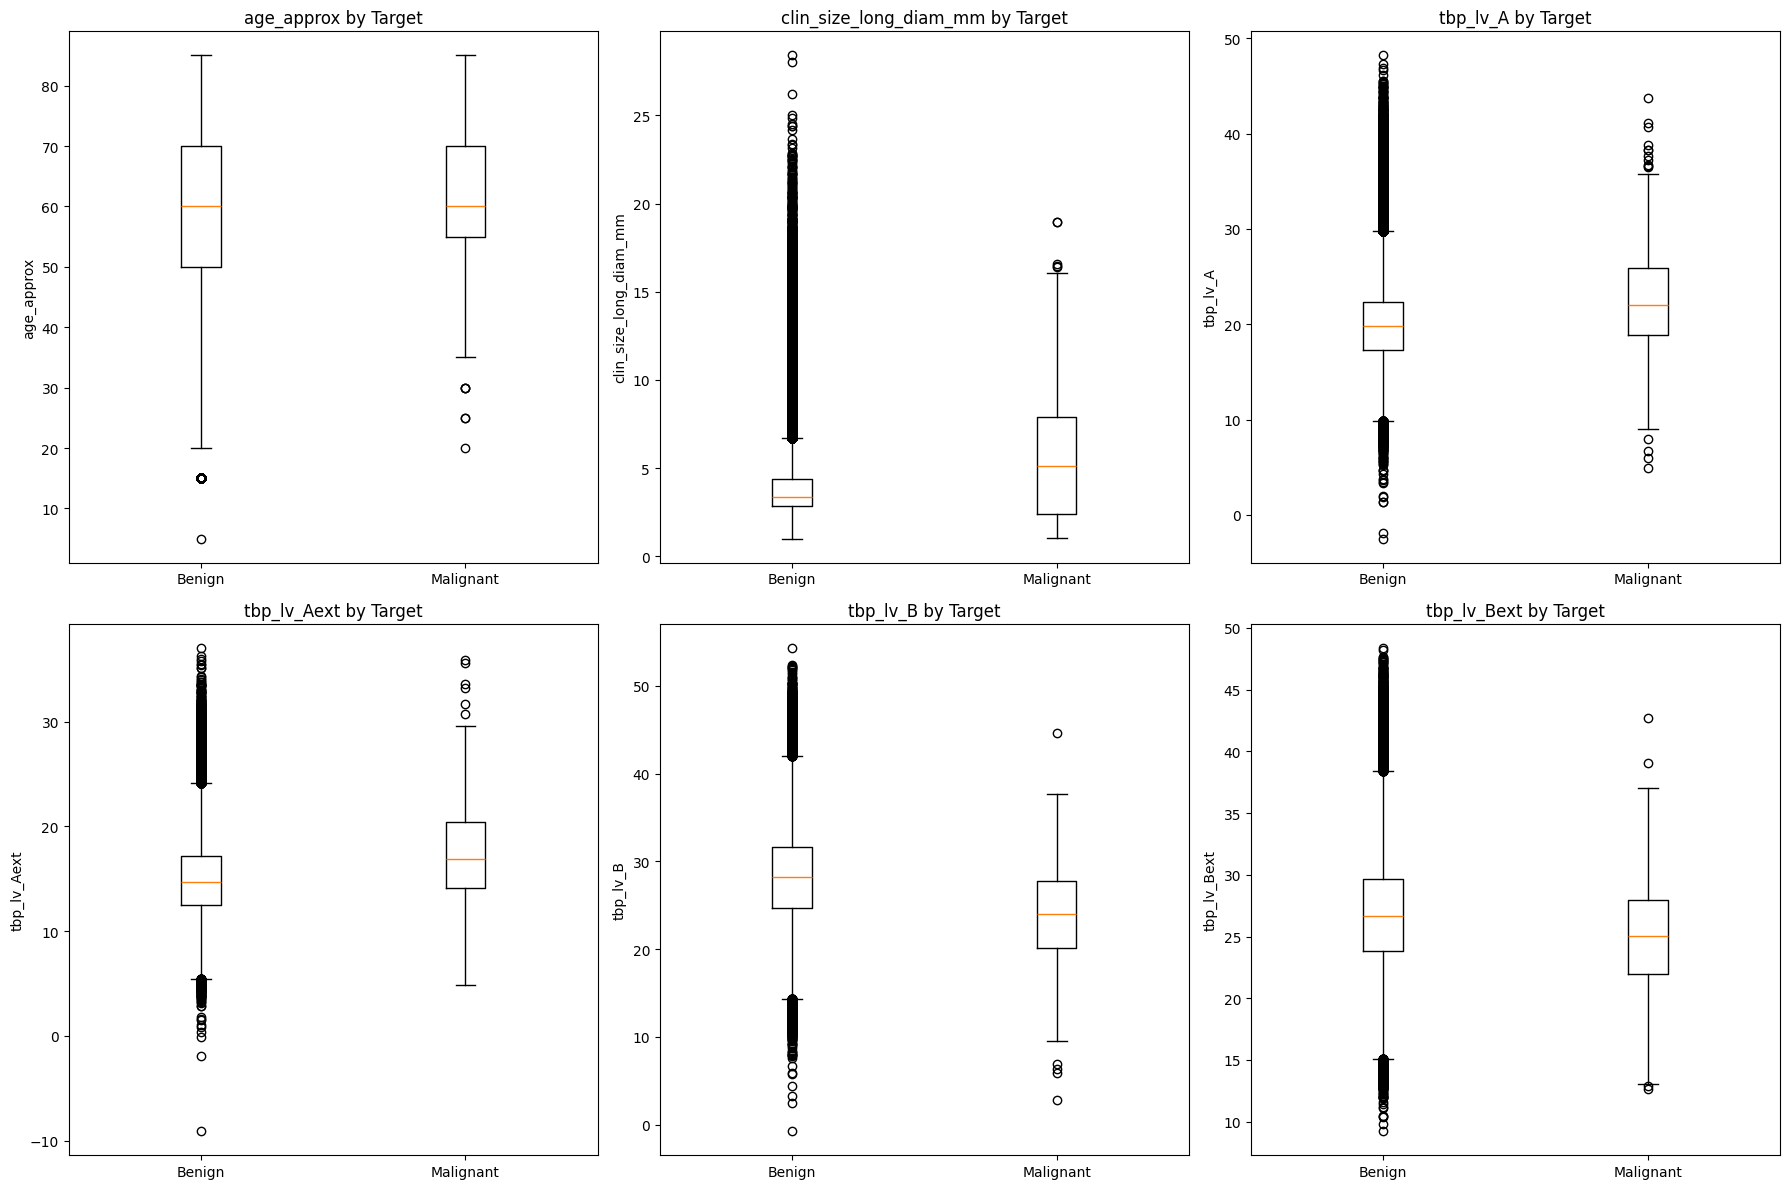

In [ ]:
# Analyze numerical features vs target
numerical_features = [
    "age_approx",
    "clin_size_long_diam_mm",
    "tbp_lv_A",
    "tbp_lv_Aext",
    "tbp_lv_B",
    "tbp_lv_Bext",
]

# Filter for existing numerical columns
existing_numerical = [
    col
    for col in numerical_features
    if col in df.columns and df[col].dtype in ["int64", "float64"]
]

if existing_numerical:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, feature in enumerate(existing_numerical[:6]):  # Limit to 6 for visualization
        # Box plot by target
        benign_data = df[df["target"] == 0][feature].dropna()
        malignant_data = df[df["target"] == 1][feature].dropna()

        axes[i].boxplot(
            [benign_data, malignant_data], tick_labels=["Benign", "Malignant"]
        )
        axes[i].set_title(f"{feature} by Target")
        axes[i].set_ylabel(feature)

        # Print statistics
        print(f"\n{feature} statistics:")
        print(f"Benign - Mean: {benign_data.mean():.3f}, Std: {benign_data.std():.3f}")
        print(
            f"Malignant - Mean: {malignant_data.mean():.3f}, Std: {malignant_data.std():.3f}"
        )

    # Hide unused subplots
    for j in range(len(existing_numerical), 6):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No suitable numerical features found for analysis")


sex distribution:
sex
male      265546
female    123996
Name: count, dtype: int64

Malignancy rate by sex:
sex
male      0.103184
female    0.087906
Name: target, dtype: float64

anatom_site_general distribution:
anatom_site_general
posterior torso    121902
lower extremity    103028
anterior torso      87770
upper extremity     70557
head/neck           12046
Name: count, dtype: int64

Malignancy rate by anatom_site_general:
anatom_site_general
head/neck          0.647518
anterior torso     0.093426
posterior torso    0.084494
upper extremity    0.080786
lower extremity    0.070855
Name: target, dtype: float64

image_type distribution:
image_type
TBP tile: close-up    401059
Name: count, dtype: int64

Malignancy rate by image_type:
image_type
TBP tile: close-up    0.097991
Name: target, dtype: float64

tbp_tile_type distribution:
tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64

Malignancy rate by tbp_tile_type:
tbp_tile_type
3D: white    0.170204
3D: X

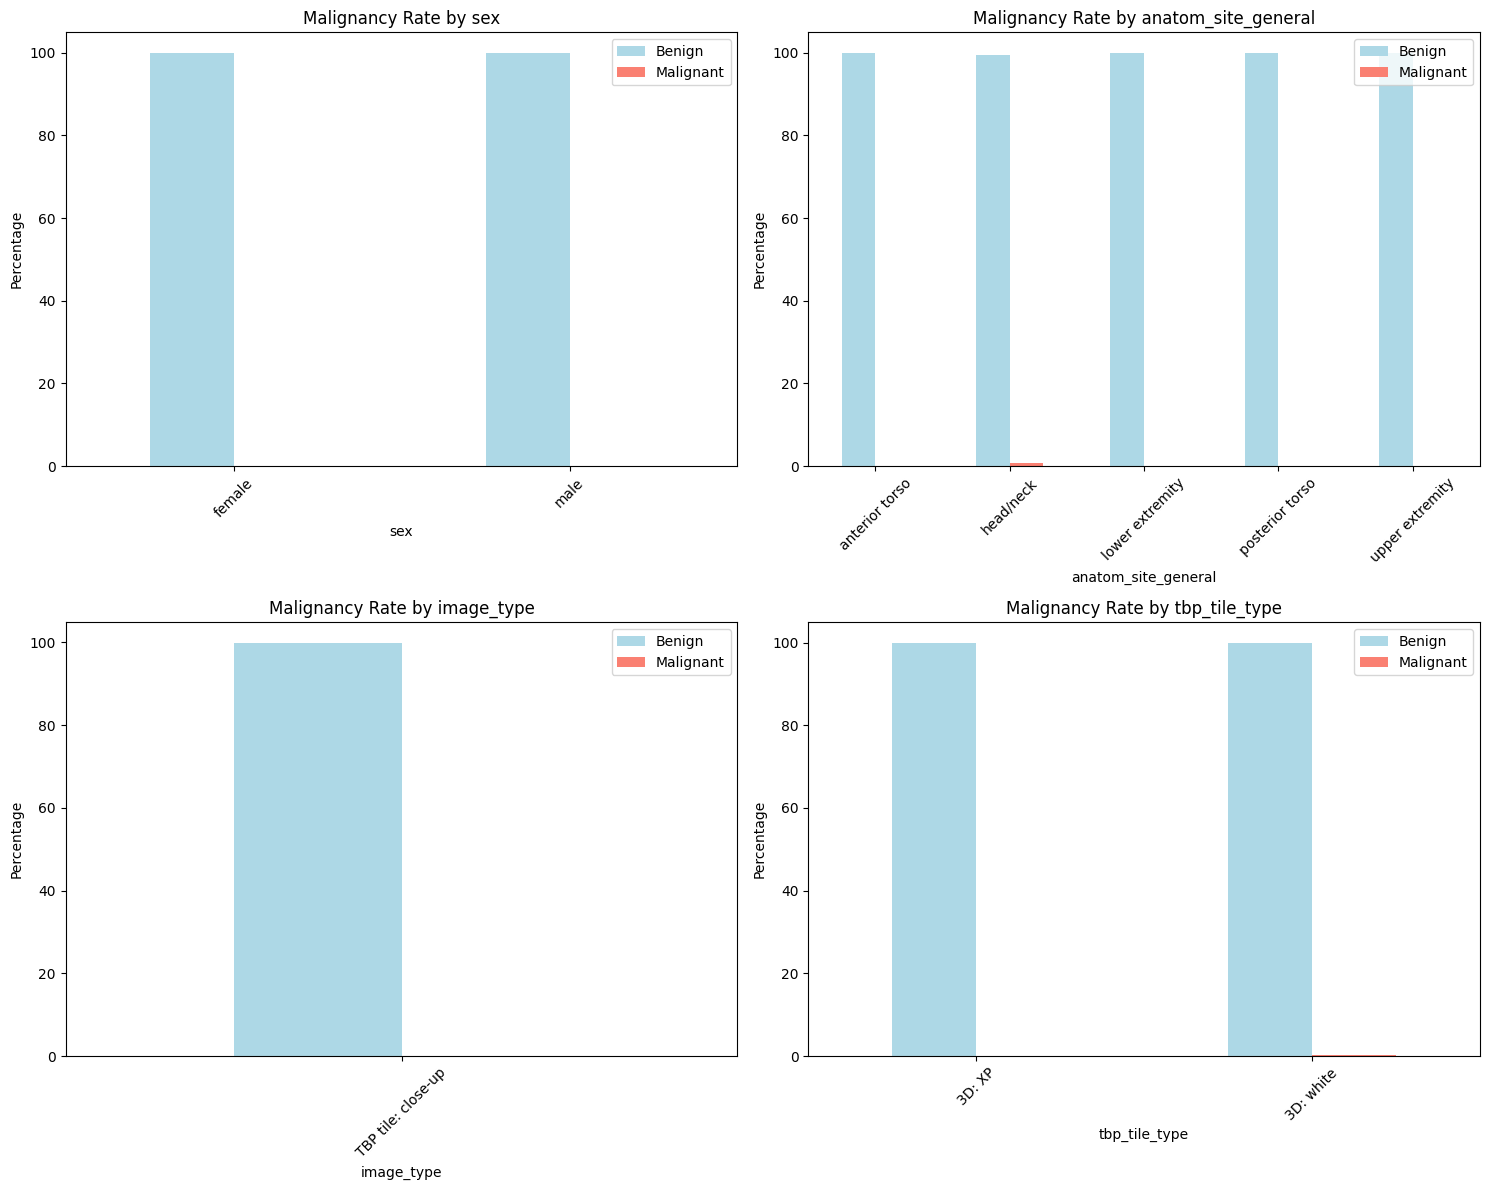

In [ ]:
# Analyze key categorical features vs target
categorical_features = ["sex", "anatom_site_general", "image_type", "tbp_tile_type"]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in df.columns:
        # Cross-tabulation
        crosstab = pd.crosstab(df[feature], df["target"], normalize="index") * 100

        crosstab.plot(kind="bar", ax=axes[i], color=["lightblue", "salmon"])
        axes[i].set_title(f"Malignancy Rate by {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Percentage")
        axes[i].tick_params(axis="x", rotation=45)
        axes[i].legend(["Benign", "Malignant"])

        # Print statistics
        print(f"\n{feature} distribution:")
        print(df[feature].value_counts())
        print(f"\nMalignancy rate by {feature}:")
        malignancy_rate = df.groupby(feature)["target"].mean() * 100
        print(malignancy_rate.sort_values(ascending=False))

plt.tight_layout()
plt.show()

Columns with missing values:
             Column  Missing_Count  Missing_Percentage
             iddx_5         401058           99.999751
  mel_mitotic_index         401006           99.986785
       mel_thick_mm         400996           99.984292
             iddx_4         400508           99.862614
             iddx_3         399994           99.734453
             iddx_2         399991           99.733705
          lesion_id         379001           94.500061
                sex          11517            2.871647
anatom_site_general           5756            1.435200
         age_approx           2798            0.697653


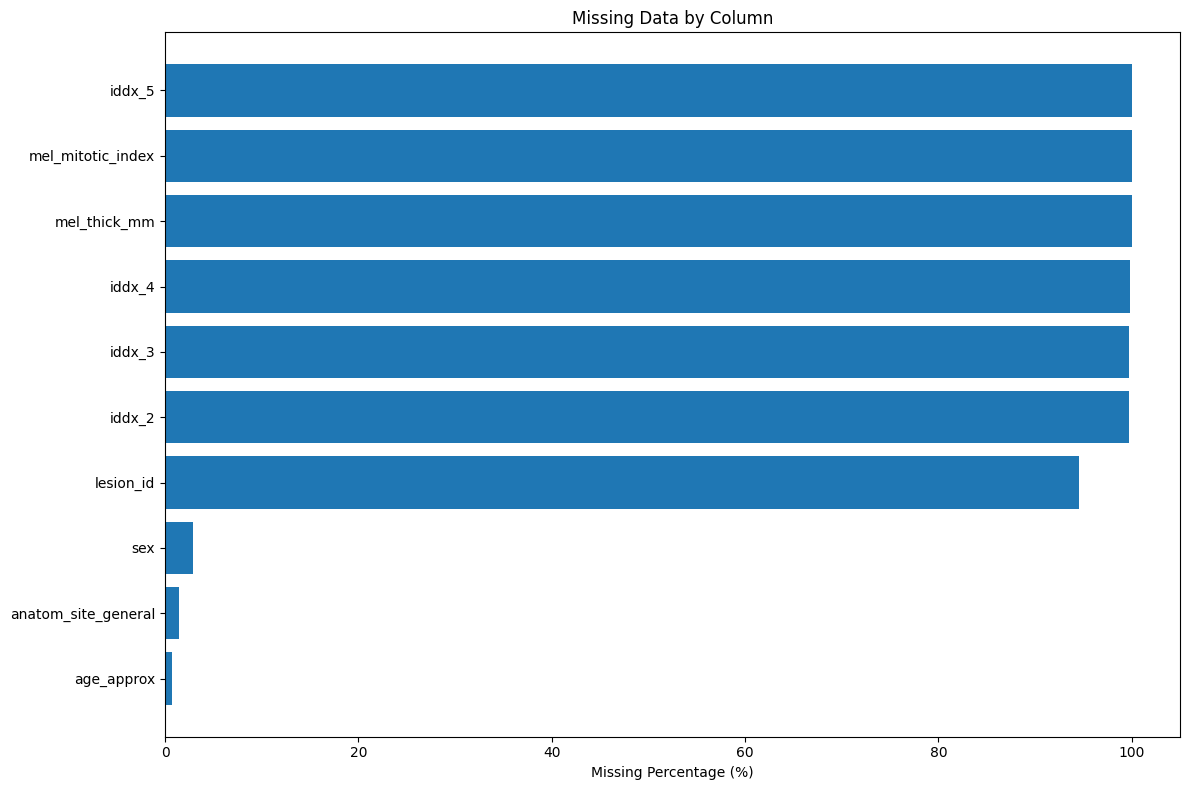

In [ ]:
# Data quality analysis - missing values
missing_data = pd.DataFrame(
    {
        "Column": df.columns,
        "Missing_Count": df.isnull().sum(),
        "Missing_Percentage": (df.isnull().sum() / len(df)) * 100,
    }
)
missing_data = missing_data[missing_data["Missing_Count"] > 0].sort_values(
    "Missing_Percentage", ascending=False
)

print("Columns with missing values:")
print(missing_data.to_string(index=False))

# Visualize missing data pattern
if not missing_data.empty:
    plt.figure(figsize=(12, 8))
    plt.barh(missing_data["Column"], missing_data["Missing_Percentage"])
    plt.xlabel("Missing Percentage (%)")
    plt.title("Missing Data by Column")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\nNo missing values found in the dataset!")

In [ ]:
# Overview of all metadata columns
print(f"Dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nColumn names and types:")
for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes)):
    print(f"{i + 1:2d}. {col:<30} ({dtype})")

Dataset shape: (401059, 55)
Total columns: 55
Memory usage: 480.1 MB

Column names and types:
 1. isic_id                        (object)
 2. target                         (int64)
 3. patient_id                     (object)
 4. age_approx                     (float64)
 5. sex                            (object)
 6. anatom_site_general            (object)
 7. clin_size_long_diam_mm         (float64)
 8. image_type                     (object)
 9. tbp_tile_type                  (object)
10. tbp_lv_A                       (float64)
11. tbp_lv_Aext                    (float64)
12. tbp_lv_B                       (float64)
13. tbp_lv_Bext                    (float64)
14. tbp_lv_C                       (float64)
15. tbp_lv_Cext                    (float64)
16. tbp_lv_H                       (float64)
17. tbp_lv_Hext                    (float64)
18. tbp_lv_L                       (float64)
19. tbp_lv_Lext                    (float64)
20. tbp_lv_areaMM2                 (float64)
21. tbp_lv_are

# Class Distribution


Class Distribution:
Benign (0): 400,666 samples (99.90%)
Malignant (1): 393 samples (0.10%)

Class Imbalance Ratio: 1019.5:1 (benign:malignant)


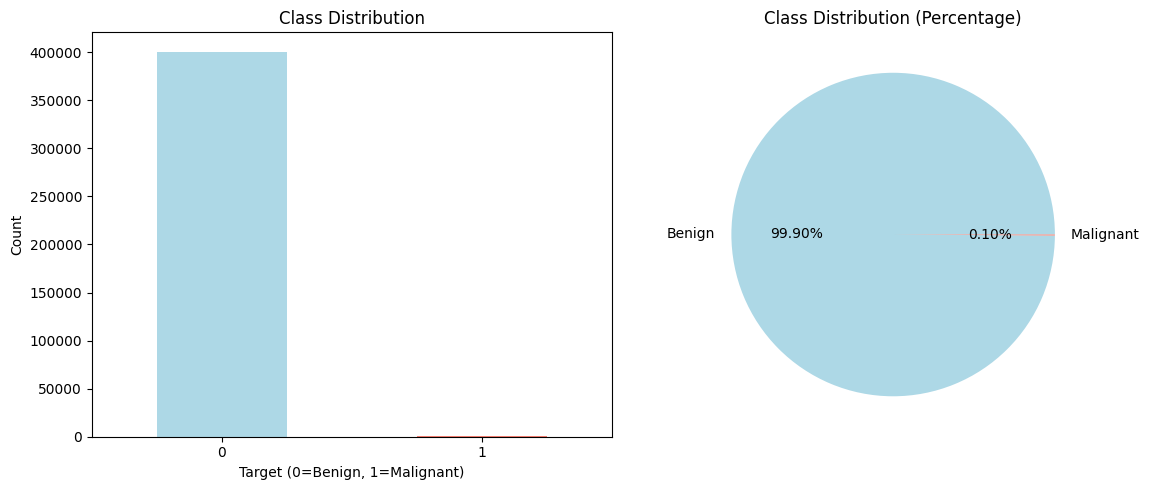

In [ ]:
# Analyze class balance
class_counts = df["target"].value_counts()
class_percentages = df["target"].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"Benign (0): {class_counts[0]:,} samples ({class_percentages[0]:.2f}%)")
print(f"Malignant (1): {class_counts[1]:,} samples ({class_percentages[1]:.2f}%)")
print(
    f"\nClass Imbalance Ratio: {class_counts[0] / class_counts[1]:.1f}:1 (benign:malignant)"
)

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
class_counts.plot(kind="bar", ax=ax1, color=["lightblue", "salmon"])
ax1.set_title("Class Distribution")
ax1.set_xlabel("Target (0=Benign, 1=Malignant)")
ax1.set_ylabel("Count")
ax1.tick_params(axis="x", rotation=0)

# Pie chart
ax2.pie(
    class_counts.values,
    labels=["Benign", "Malignant"],
    autopct="%1.2f%%",
    colors=["lightblue", "salmon"],
)
ax2.set_title("Class Distribution (Percentage)")

plt.tight_layout()
plt.show()